In [1]:
# import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from data_utils import *

In [2]:
data_dir = '../data/'

# load the data
grf_data = np.load(data_dir + 'grf.npy', mmap_mode='r')
muscle_data = np.load(data_dir + 'muscle.npy', mmap_mode='r')

grf_labels = ['GRF_x', 'GRF_y', 'GRF_z']
muscle_labels = ['tibpost', 'tibant', 'edl', 'ehl', 'fdl', 'fhl', 'perbrev', 'perlong', 'achilles']

grf_dict = {0: 'GRF_x', 1: 'GRF_y', 2: 'GRF_z'}
muscle_dict = {0: 'tibpost', 1: 'tibant', 2: 'edl', 3: 'ehl', 4: 'fdl', 5: 'fhl', 6: 'perbrev', 7: 'perlong', 8: 'achilles'}

In [3]:
data = np.concatenate((grf_data, muscle_data), axis=2)
# print(data.shape)

np.random.seed(42)
np.random.shuffle(data)

In [4]:
num_samples = data.shape[0]
train_size = int(0.8 * num_samples)
val_size = int(0.1 * num_samples)

print(f"Number of samples: {num_samples}")
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")

Number of samples: 13388
Train size: 10710
Validation size: 1338


In [5]:
train_data = data[:train_size]
val_data = data[train_size:train_size+val_size]
test_data = data[train_size+val_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (10710, 100, 12)
Validation data shape: (1338, 100, 12)
Test data shape: (1340, 100, 12)


In [6]:
X_train, y_train = train_data[:, :, :3], train_data[:, :, 3:]
X_val, y_val = val_data[:, :, :3], val_data[:, :, 3:]
X_test, y_test = test_data[:, :, :3], test_data[:, :, 3:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (10710, 100, 3)
y_train shape: (10710, 100, 9)
X_val shape: (1338, 100, 3)
y_val shape: (1338, 100, 9)
X_test shape: (1340, 100, 3)
y_test shape: (1340, 100, 9)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.]),
 [Text(0, -1000.0, '−1000'),
  Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000')])

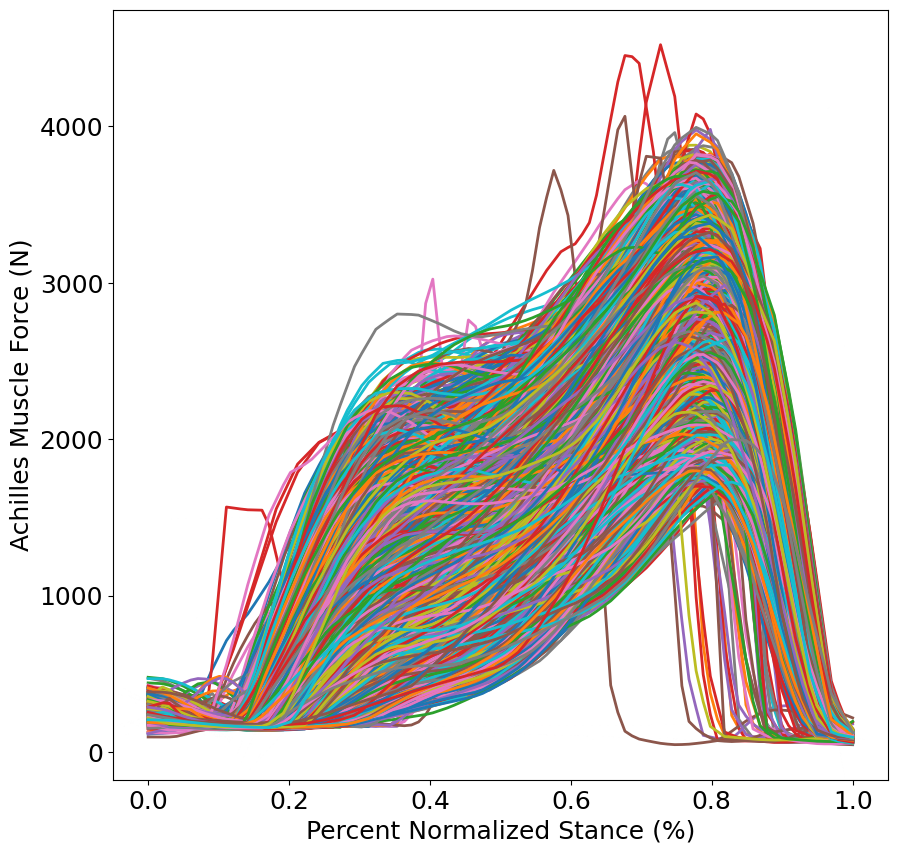

In [7]:
figure = plt.figure(figsize=(10, 10))

num_achilles_segments = len(y_train[:, :, 8])
perc_stance = np.linspace(0, 1, 100)

for i in range(num_achilles_segments):
    plt.plot(perc_stance, y_train[i, :, 8], linewidth=2)

plt.ylabel("Achilles Muscle Force (N)", fontsize=18)
plt.xlabel("Percent Normalized Stance (%)", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.0):
        super(CNNLSTMModel, self).__init__()
        
        # define the CNN
        self.cnn = nn.Sequential(
            # nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            nn.Conv1d(input_size, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1, padding=1),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=1)
        )
        
        # define the LSTM
        self.lstm = nn.LSTM(128, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)  # x shape: (batch_size, grf_dim, seq_len)
        
        # input: (N, C_in, L_in)
        # output: (N, C_out, L_out)
        cnn_out = self.cnn(x)  # cnn_out shape: (batch_size, feature_map_dim, seq_len)

        # permute the dimensions of the output of the CNN
        # (N, C_out, L_out) -> (N, L_out, C_out)
        cnn_out = cnn_out.permute(0, 2, 1)  # cnn_out shape: (batch_size, seq_len, feature_map_dim)
        
        # batch_first=True, so the input and output tensors are provided as (batch, seq, feature)
        # input: (N, L, H_in), H_in = input_size
        # output: (N, L, H_out), H_out = hidden_size
        lstm_out, _ = self.lstm(cnn_out)  # lstm_out shape: (batch_size, seq_len, hidden_size)
        
        # input: (N, *, H_in)
        # output: (N, *, H_out)
        output = self.fc(lstm_out)  # output shape: (batch_size, seq_len, output_size)
        
        return output
    

In [9]:
# define device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [10]:
# model parameters
input_size = 3
hidden_size = 64
num_layers = 2
output_size = 9

# model hyperparameters
dropout_rate = 0.25
learning_rate = 1e-3
batch_size = 32
regularization = 1e-3
num_epochs = 1000

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# convert your data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

# create torch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# create dataloaders from datasets
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [12]:
model = CNNLSTMModel(input_size, hidden_size, num_layers, output_size)
model.to(device)

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=9, bias=True)
)

In [13]:
# early stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# training loop
for epoch in range(num_epochs):
    # set model to training mode
    model.train()
    
    # initialize training loss
    train_loss = 0
    
    # iterate over the training data
    for X_batch, y_batch in train_loader:
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # update training loss
        train_loss += loss.item() * X_batch.size(0)
    
    # average training loss over number of samples
    train_loss /= len(train_loader.dataset)
    
    # set model to evaluation mode
    model.eval()
    
    # initialize validation loss
    val_loss = 0
    
    # no need to calculate gradients during validation
    with torch.no_grad():
        # iterate over the validation data
        for X_batch, y_batch in val_loader:
            # forward pass
            outputs = model(X_batch)
            
            # calculate loss
            loss = criterion(outputs, y_batch)
            
            # update validation loss
            val_loss += loss.item() * X_batch.size(0)
    
    # average validation loss over number of samples
    val_loss /= len(val_loader.dataset)
    
    # print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
    # early stopping check
    if val_loss < best_val_loss:
        # save best validation loss
        best_val_loss = val_loss
        
        # reset epochs without improvement
        epochs_without_improvement = 0
    else:
        # increment epochs without improvement
        epochs_without_improvement += 1

    # break if patience limit is reached
    if epochs_without_improvement >= patience:
        break

Epoch [10/1000], Train Loss: 209747.4996, Val Loss: 207681.0697
Epoch [20/1000], Train Loss: 165461.7767, Val Loss: 163883.3870
Epoch [30/1000], Train Loss: 128606.7180, Val Loss: 127366.8018
Epoch [40/1000], Train Loss: 98305.1990, Val Loss: 97377.8326
Epoch [50/1000], Train Loss: 73666.1500, Val Loss: 72986.4691
Epoch [60/1000], Train Loss: 53950.8920, Val Loss: 53439.7746
Epoch [70/1000], Train Loss: 38603.8752, Val Loss: 38433.0407
Epoch [80/1000], Train Loss: 26982.9165, Val Loss: 26802.7541
Epoch [90/1000], Train Loss: 18516.6097, Val Loss: 18379.3720
Epoch [100/1000], Train Loss: 12370.1551, Val Loss: 12354.6371
Epoch [110/1000], Train Loss: 8245.8666, Val Loss: 8302.8145
Epoch [120/1000], Train Loss: 5474.7565, Val Loss: 5603.5976
Epoch [130/1000], Train Loss: 3882.6578, Val Loss: 3951.8577
Epoch [140/1000], Train Loss: 2971.9178, Val Loss: 3059.9279
Epoch [150/1000], Train Loss: 2437.7523, Val Loss: 2565.3336
Epoch [160/1000], Train Loss: 2140.6082, Val Loss: 2335.9427
Epoch [

In [14]:
# convert test data to torch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# set model to evaluation mode
model.eval()

# initialize test loss
test_loss = 0

# no need to calculate gradients during testing
with torch.no_grad():
    # forward pass
    test_outputs = model(X_test_tensor)
    
    # calculate loss
    test_loss = criterion(test_outputs, y_test_tensor).item()

# print test loss
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 1848.1052


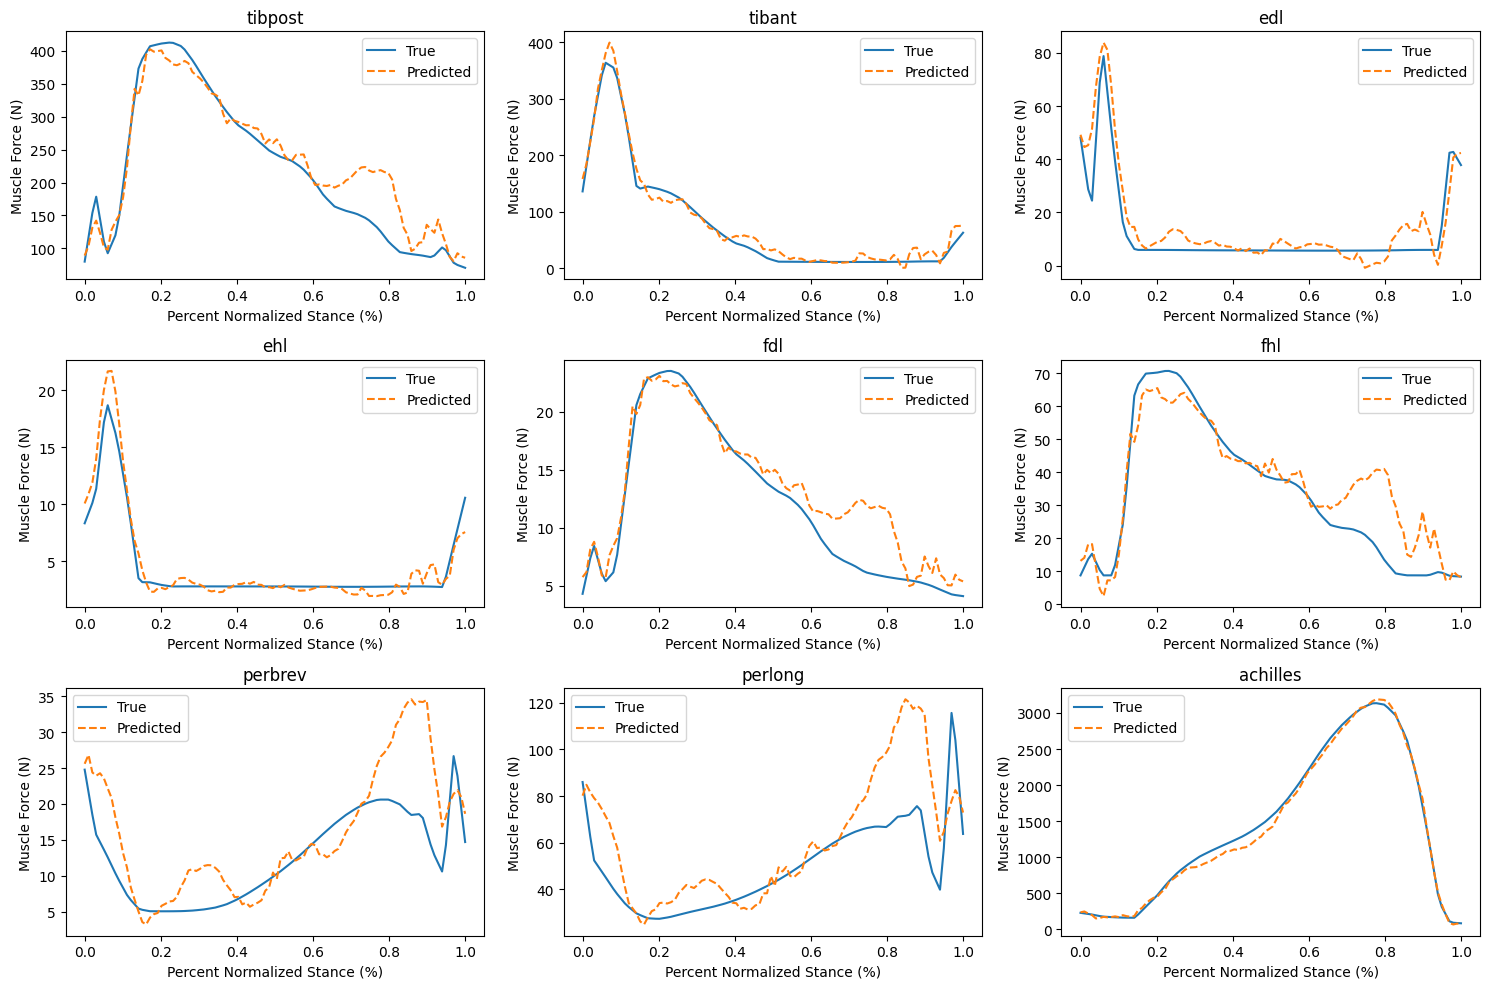

In [15]:
# Move predictions and ground truth to CPU for visualization
pred = test_outputs[0].cpu().numpy()  # Shape: (seq_length, 9)
true = y_test_tensor[0].cpu().numpy()      # Shape: (seq_length, 9)

fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # Create subplots for 9 muscles
axes = axes.flatten()

for i in range(9):
    axes[i].plot(perc_stance, true[:, i], label="True")
    axes[i].plot(perc_stance, pred[:, i], label="Predicted", linestyle='dashed')
    axes[i].set_title(muscle_dict[i])
    axes[i].set_xlabel("Percent Normalized Stance (%)")
    axes[i].set_ylabel("Muscle Force (N)")
    axes[i].legend()

plt.tight_layout()
plt.show()